# Naive Bayes 

Throughout the following exercises, you will learn to use Python to construct and test a Naive Bayes model with scikit-learn. Before starting on this programming exercise, we strongly recommend watching the video lecture and completing the IVQ for the associated topics.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. 

Topics of focus include:

* Relevant import statements
* Stratification during data splitting
* Fitting a Naive Bayes model
* Evaluating the model on test data


As we move forward, you can find instructions on how to install required libraries as they arise in this notebook. 

## Modeling objective

The modeling objective is to build and test a Naive Bayes model that uses banking data to predict whether a customer will churn. If a customer churns, it means they left the bank and took their business elsewhere. If we can predict customers who are likely to churn, we can take measures to retain them before they do. These measures could be promotions, discounts, or other incentives to boost customer satisfaction and, therefore, retention.

### Target variable

Remember, our target variable is called `Exited`. This is a Boolean value that indicates whether or not a customer left the bank (0 = did not leave, 1 = did leave). For each customer, our model will predict whether they should have a 0 or a 1 in the `Exited` column.

### IMPORTANT: Model design

This is a classification task, because we are trying to predict on a binary class. Naive Bayes often works well for this kind of task. However, recall that there are several different implementations of the Naive Bayes algorithm in scikit-learn, and each assumes that all of your predictor variables are of a single type (e.g., Gaussian for continuous variables, Bernoulli for binary variables, etc.). 

Our data has all different types of predictor variables! As a data professional, one of the first things you'll learn on the job is that real-world data is never perfect. Sometimes the data breaks the assumptions of your model. In practice, you'll have to do the best you can with what you have. 

In this case, if we wanted to build the best possible Naive Bayes model, we'd treat each variable according to their different types and distributions, and then combine each conditional probability to get the final prediction for each observation. That's advanced data science, and beyond the scope of this course. 

For this lesson, we're going to use the `GaussianNB` classifier. This implementation assumes that all of your variables are continuous _and_ that they have a Gaussian (i.e., normal) distribution. Our data doesn't perfectly adhere to these assumptions, but a Gaussian model may still yield usable results, even with imperfect data.

## Import statements

Before we begin with the exercises and analyzing the data, we need to import all libraries and extensions required for this programming exercise. Throughout the course, we will be using numpy and pandas for operations, and matplotlib for plotting.

Notice that we're getting `GaussianNB` from the `sklearn.naive_bayes` module. If you wanted, you could get the other implementations of Naive Bayes from this same module. Refer to the [documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes) for details.

We'll also import some evaluation metrics from `sklearn.metrics` and some functions that will help us generate and plot a confusion matrix.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Read in the data

We're going to use the prepared dataframe that we made in the previous notebook. Remember, we:

* Dropped the `RowNumber`, `CustomerId`, `Surname`, and `Gender` columns
* Dummy encoded the `Geography` column to convert categorical to Boolean
* Engineered a new feature called `Loyalty`, by dividing each customer's tenure by their age

In [2]:
churn_df = pd.read_csv('churn_df.csv')
churn_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0.047619,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.024390,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0.190476,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0.025641,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0.046512,0,1


## Check the class balance

Before we begin modeling, let's do a few more things. First, we'll check the class balance of the `Exited` column, our target variable.

In [3]:
# Check class balance
churn_df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

The class is split roughly 80/20. In other words, ~20% of the people in this dataset churned. This is an unbalanced dataset, but it's not extreme. 

Also, remember that the Naive Bayes formula depends on class priors _(P(c))_ to make predictions. Because of this, performing class balancing (e.g., upsampling or downsampling) would change those terms in a way that would no longer reflect the real-world distribution of the data.

For these reasons, we'll proceed without altering the class balance of our target variable.

## Drop dependent variables

Remember that Naive Bayes models operate best when there's conditional independence between the predictor variables. When we prepared our data, we engineered a feature called `Loyalty` by dividing `Tenure` by `Age`. Because this new feature is just the quotient of two existing variables, it's no longer conditionally independent. Therefore, we'll drop `Tenure` and `Age` to help adhere to the assumptions of our model.

In [4]:
# Drop Tenure and Age variables
churn_df = churn_df.drop(['Tenure', 'Age'], axis=1)
churn_df.head()

,CreditScore,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty,Geography_Germany,Geography_Spain
0,619,0.00,1,1,1,101348.88,1,0.047619,0,0
1,608,83807.86,1,0,1,112542.58,0,0.024390,0,1
2,502,159660.80,3,1,0,113931.57,1,0.190476,0,0
3,699,0.00,2,0,0,93826.63,0,0.025641,0,0
4,850,125510.82,1,1,1,79084.10,0,0.046512,0,1


## Split the data

We've prepared our data and we're ready to model. There's one last step before we can begin. We must split the data into features and target variable, and into training data and test data. We do this using the `train_test_split()` function. We'll put 25% of the data into our test set, and use the remaining 75% to train the model.

Notice below that we include the argument `stratify=y`. If our master data has a class split of 80/20, stratifying ensures that this proportion is maintained in both the training and test data. `=y` tells the function that it should use the class ratio found in the `y` variable (our target).

The less data you have overall, and the greater your class imbalance, the more important it is to stratify when you split the data. If we didn’t stratify, then the function would split the data randomly, and we could get an unlucky split that doesn’t get any of the minority class in the test data, which means we wouldn’t be able to effectively evaluate our model. Worst of all, we might not even realize what went wrong without doing some detective work.

Lastly, we set a random seed so we and others can reproduce our work.

In [5]:
# Define the y (target) variable
y = churn_df['Exited']

# Define the X (predictor) variables
X = churn_df.copy()
X = X.drop('Exited', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, \
                                                    stratify=y, random_state=42)

## Modeling

### 1. Unscaled data

We're finally ready to model! Just as with linear and logistic regression, our modeling process will begin with fitting our model to the training data, and then using the model to make predictions on the test data. 

In [6]:
# Fit the model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Get the predictions on test data
y_preds = gnb.predict(X_test)

Now we can check how our model performs using the evaluation metrics we imported.

In [7]:
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_preds))
print('Precision:', '%.3f' % precision_score(y_test, y_preds))
print('Recall:', '%.3f' % recall_score(y_test, y_preds))
print('F1 Score:', '%.3f' % f1_score(y_test, y_preds))

Accuracy: 0.796
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


Hmm… this isn’t very good. Our precision, recall, and F1 scores are all zero. What’s going on? Well, let’s consider our precision formula: 
</br>  
$$precision = \frac{\text{true positives}}{\text{false positives + true positives}}$$
  </br> 

There are two ways for the model to have a precision of zero. The first is if the numerator is zero, which would mean that our model didn’t predict any true positives. 

The second is if the denominator is also zero, which would mean that our model didn’t predict any positives at all. Dividing by zero results in an undefined value, but scikit-learn will return a value of zero in this case. Depending on your modeling environment, you may get a warning that tells you there’s a denominator of zero. 

We don’t have a warning, so let’s check which situation is occurring here. If we call `np.unique()` on the model's predictions and it doesn't return an array containing `[0, 1]`, we'll know it's not predicticting any churned customers.

In [8]:
# Check unique values in predictions
np.unique(y_preds)

array([0])

This confirms that the model predicted 0 (not churned) for every sample in the test data. 
  
Consider why this might be. Perhaps we did something wrong in our modeling process, or maybe using `GaussianNB` on predictor variables of different types and distributions just doesn't make a good model. Maybe there were problems with the data. 

Before we give up, maybe the data can give us some insight into what might be happening or what further steps we can take. Let's use `describe()` to inspect the X data.

In [9]:
# Get descriptive stats for data
X.describe()

,CreditScore,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Loyalty,Geography_Germany,Geography_Spain
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.137936,0.250900,0.247700
std,96.653299,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.089506,0.433553,0.431698
min,350.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000
25%,584.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.064516,0.000000,0.000000
50%,652.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.129032,0.000000,0.000000
75%,718.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.200000,1.000000,0.000000
max,850.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,0.555556,1.000000,1.000000


Something that stands out is that the `Loyalty` variable we created is on a vastly different scale than some of the other variables we have, such as `Balance` or `EstimatedSalary`. The maximum value of `Loyalty` is 0.56, while the maximum for `Balance` is over 250,000&mdash;almost six orders of magnitude greater!

### 2. Scaled data

One thing that you can usually try when modeling is scaling your predictor variables. Some models require you to scale the data in order for them to operate as expected, others don't. Naive Bayes does not require data scaling. However, sometimes packages and libraries need to make assumptions and approximations in their calculations. We're already breaking some of these assumptions by using the `GaussianNB` classifier on this dataset, and it may not be helping that some of our predictor variables are on very different scales. In general, scaling might not improve the model, but it probably won't make it worse. Let's try scaling our data.

We'll use a function called `MinMaxScaler`, which we'll import from the `sklearn.preprocessing` module. `MinMaxScaler` normalizes each column so every value falls in the range of [0, 1]. The column's maximum value would scale to 1, and its minimum value would scale to 0. Everything else would fall somewhere between. This is the formula:

$${x_{scaled}} = \frac{x - x_{min}}{x_{max} - x_{min}}$$ 

To use a scaler, you must fit it to the training data, and transform both the training data _and_ the test data using that same scaler. 

Let's apply this and retrain the model.

In [10]:
# Import the scaler function
from sklearn.preprocessing import MinMaxScaler

# Instantiate the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Scale the training data
X_train = scaler.transform(X_train)

# Scale the test data
X_test = scaler.transform(X_test)

Now we'll repeat the steps to fit our model, only this time we'll fit it to our new scaled data.

In [11]:
# Fit the model
gnb_scaled = GaussianNB()
gnb_scaled.fit(X_train, y_train)

# Get the predictions on test data
scaled_preds = gnb_scaled.predict(X_test)

In [12]:
print('Accuracy:', '%.3f' % accuracy_score(y_test, scaled_preds))
print('Precision:', '%.3f' % precision_score(y_test,scaled_preds))
print('Recall:', '%.3f' % recall_score(y_test, scaled_preds))
print('F1 Score:', '%.3f' % f1_score(y_test, scaled_preds))

Accuracy: 0.806
Precision: 0.544
Recall: 0.303
F1 Score: 0.389


It works now! The model is far from perfect, but at least it's predicting churned customers now. 

## Evaluation

Let's examine more closely how our model classified the test data. We'll do this with a confusion matrix. Recall that a confusion matrix is a graphic that shows your models true and false positives, and true and false negatives. We can do this using the `ConfusionMatrixDisplay` and `confusion_matrix` functions that we imported.

Here's a helper function that will allow us to plot a confusion matrix for our model.

In [14]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Return a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_,
                                 )
  
    disp.plot(values_format='') # `values_format=''` suppresses scientific notation
    plt.show()

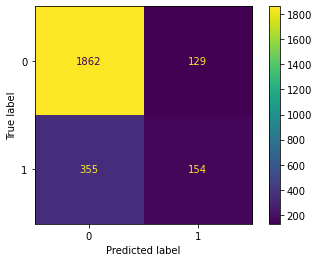

In [15]:
conf_matrix_plot(gnb_scaled, X_test, y_test)

All of our model metrics can be derived from the confusion matrix, and each metric tells its own part of the story. What stands out most in the confusion matrix is that the model misses a lot of customers who will churn. In other words, there are a lot of false negatives&mdash;355, to be exact. This is why our recall score is only 0.303. 

Would we use this model? It depends. For one thing, we'd certainly want to develop other models to see if they perform better. Later, you'll learn how to develop other classification models. You'll also learn more about evaluating your models, which takes careful decision-making and consideration for your use case.

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.

You now understand how to use Python to construct and test a Naive Bayes model. Going forward, you can start using Python to construct and test a Naive Bayes model for your own data.